In [1]:
# Import de librairies
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import scipy.stats as st
import statsmodels.api as sm
import sklearn.experimental
import sklearn.ensemble
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency as chi2_contingency
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.collections import LineCollection

In [2]:
data = pd.read_csv('dataset_projet1_nettoye.csv')

### Analyse des données

In [20]:
# Determiner les données qualitatives et quantitatives
all_col = data.columns
# données qualitatives
qual_na = ['url','product_name',"nutrition_grade_fr","main_category_fr"]
# données quantitatives
quant_na = ['additives_n', 'energy_100g', 'fat_100g','saturated_fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition_score_fr_100g']

Text(0.5, 1.0, 'Répartition des nutrition_grade')

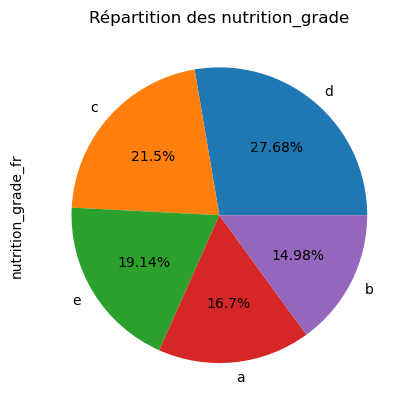

In [6]:
data["nutrition_grade_fr"].value_counts().plot(kind='pie', autopct = lambda x: str(round(x, 2)) + '%')
plt.title("Répartition des nutrition_grade")

On voit une répartition plutôt égale des scores, il n'y a pas de véritable déséquilibre entre les classes.

In [ ]:
data["main_category_fr"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show()

In [ ]:
# Diagramme en tuyaux d'orgues
data["main_category_fr"].value_counts()[1:21].plot(kind='bar')
plt.show()

In [ ]:
# Diagramme en tuyaux d'orgues
data["main_category_fr"].value_counts()[data["main_category_fr"].value_counts()>300][1:].plot(kind='bar')
plt.show()

In [ ]:
# Representation des categories au dessus de 0.5%, en retirant les catégories "manquant"
data["main_category_fr"].value_counts(normalize = True)[data["main_category_fr"].value_counts(normalize = True)>0.005][1:].plot(kind='bar')
plt.show()

In [4]:
# On modifie quelques valeurs de la variable category pour regrouper les valeurs
data.loc[(data["main_category_fr"] != 'Farine-a-gateau') & ((data["main_category_fr"].str.find('Gateau') != -1) | (data["main_category_fr"].str.find('gateau') != -1) | (data["main_category_fr"].str.find('gâteau') != -1)),'main_category_fr'] = 'Gâteaux'
data.loc[(data["main_category_fr"].str.find('Jus') != -1) | (data["main_category_fr"].str.find('jus') != -1), 'main_category_fr'] = "Jus de fruits"
data.loc[(data["main_category_fr"].str.find('Poisson') != -1) | (data["main_category_fr"].str.find('poisson') != -1), 'main_category_fr'] = "Poissons"
data.loc[(data["main_category_fr"].str.find('Biscuits') != -1) | (data["main_category_fr"].str.find('biscuits') != -1), 'main_category_fr'] = "Biscuits" 

In [5]:
# On recupère les valeurs des categories qui sont representées à hauteur de moins de 0.5% dans une liste

seuil = 0.005 # Le seuil fixé est de 0.5% 
name = (data["main_category_fr"].value_counts(normalize = True)[data["main_category_fr"].value_counts(normalize = True)<seuil][1:,]).index.tolist()

In [6]:
# Pour chaque ligne du dataframe 
# Si la valeur de main_category_fr est présente dans la liste des valeurs inférieures à 0.5% 
# Alors on la remplace par la valeur Autres
for label, row in data.iterrows():
    if (row["main_category_fr"] in name) : 
        data.loc[label,'main_category_fr'] = 'Autres'

In [ ]:
data["main_category_fr"].value_counts(normalize = True)[1:].plot(kind='bar')
plt.show()

In [ ]:
# On ne voit pas vraiment à l'aide d'un piechart
data["main_category_fr"].value_counts(normalize=True)[1:].plot(kind='pie')
plt.show()

In [ ]:
# On ne voit pas vraiment à l'aide d'un piechart, c'est logique, on a bien pleins de noms de produits différents
# Donc cela se comporte comme des identifiants et il n'y a pas d'intérêt à faire des représentations de cette variable 
# data["product_name"].value_counts(normalize=True)[1:].plot(kind='pie')
# plt.show()

In [ ]:
data["product_name"].value_counts(normalize=True)[0:10].plot(kind='bar')
plt.show()
# On peut juste observer les valeurs les plus représentées mais qui represente toutes moins de 0.06% du dataset (environ 30 valeurs)

In [ ]:
data["nutrition_grade_fr"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

On remarque que le nutrigrade le plus elevé est d est le plus faible est b.  
Globalement, on a plus de produits "mal" notés donc moins sains que de produits sains.  
On a environ 47% de prouits qui sont soit D soit E et environ 32% de produits qui sont soit A ou soit B.
C'est normal car les produits les mieux notés sont souvent les plus chers et les gens ont tendance à acheter les produits les moins chers, donc les moins bien noté. Ca n'est pas en contradiction avec nos données. C'est une bonne chose. 

In [ ]:
data["additives_n"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

On remarque que les produits contiennent plus frequemment 2 additifs, ce qui est normal car lors de l'imputation, la valeur qui remplaçait les valeurs nulles était 1.6 environ et on a arrondi à l'entier le plus proche donc 2.  
Ensuite, près de 25% des produits ne contiennent pas d'additifs et les autres proportions se situent proche de 10% ou en dessous.

In [ ]:
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        sns.boxplot(x=data[elem])
        plt.show()

On remarque donc que les boxplots sont très différents pour chacune des variables.  
On a des variables qui vont se regrouper autour de valeurs plus faibles comme le sel, les fibres ou les additifs et des variables qui vont se regrouper autour de valeurs un peu plus élevées comme les protéines, les graisses, le sucre ou les carbohydrates.  
Ensuite on va avoir des valeurs beaucoup plus élevées pour l'energy car l'unité est différente (on parle de KJ) et une répartition homogène des valeurs pour le nutriscore car les valeurs peuvent être contenues entre *-15* et *40*.  

Ces résultats nous paraissent logique car les aliments contiennent généralement peu de sel et de fibre et qu'on retrouve plus facilement les autres nutriments (sauf exception). 

In [ ]:
# On peut opter pour une représentation à l'aide d'histogramme pour avoir un autre type de représentation
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        plt.hist(data[elem], label=elem) 
        plt.legend(loc='upper right')
        plt.show()

A partir des ces analyses, on arrive à voir que la plupart des variables quantitatives suivent une distribution anormale asymétrique et étalée à droite.  
Seule la variale nutriscore semble suivre une distribution normale symétrique.

In [ ]:
df_min_max_scaled = data.copy()

In [ ]:
# Appliquer des techniques de normalisation
for column in data[quant_na]:
    df_min_max_scaled[column] = MinMaxScaler().fit_transform(df_min_max_scaled[column].values.reshape(-1, 1))

In [ ]:
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        skew = data[elem].skew()
        print('Le skewness de', elem, 'est', skew)

In [ ]:
for elem in data[quant_na] :
    skew = df_min_max_scaled[elem].skew()
    print('Le skewness de', elem, 'est', skew)

Comme notre analyse des histogrammes nous l'avait révelé, on observe que la plupart des distributions sont étalées à droite (car skewness > 0), sauf pour le nutriscore qui a un skewness proche de 0 donc sa distribution est relativement symétrique.

In [ ]:
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        kurtosis = data[elem].kurtosis()
        print('Le kurtosis de', elem, 'est', kurtosis)

In [ ]:
for elem in data[quant_na] :
    kurtosis = df_min_max_scaled[elem].kurtosis()
    print('Le kurtosis de', elem, 'est', kurtosis)

Le fait de normaliser les données ne change pas nos résultats. 

Grâce à cette analyse, on voit que la totalité des variables n'ont pas le même aplatissement que la distribution normale.  
Les variables suivantes sont plus aplaties que la ditribution normale : *energy_100g, carbohydrates_100g, nutrition-score-fr_100g* (car le kurtosis<0). Cela signifie que les observations sont moins concentrées.  
Le reste des variables est moins aplatie que la ditribution normale (car le kurtosis>0). Cela signifie que les observations sont plus concentrées.  
La variable qui se rapproche le plus de l'aplatissement de la distribution normale est *carbohydrates_100g* (car kurtosis le plus proche de 0).

In [ ]:
for elem in data.columns :
    if data[elem].dtypes == 'float64' :
        dep = data[elem].values
        n = len(dep)
        lorenz = np.cumsum(np.sort(dep)) / dep.sum()
        lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
        xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
        plt.plot(xaxis,lorenz,drawstyle='steps-post', label=elem)
        plt.legend()
        plt.show()
        AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
        S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
        gini = 2*S
        print("Gini :",gini)

Les variables ont l'air d'être plutôt bien réparties au sein des populations, on ne remarque pas d'inégalité de répartition flagrante. Il n'y a pas vraiment de biais. 

## Analyse bivariée

### Relation variable Qualitative/Qualitative

In [ ]:
sns.pairplot(data,diagonal = 'kde')

On retient des variables qui sont plus ou moins corrélées. En particulier, on remarque que les additifs ne sont pas vraiment corrélés au reste des variables.  
Par contre on remarque un certain nombre de variables corrélées au **nutriscore** en particulier les variables suivantes :  
- **fat_100g**
- **saturated-fat_100g**
- **sugars_100g**
- **salt_100g**
- **energy_100g** ?  
Ces variables sont toutes corrélées positivement avec le nutriscore, ce qui me paraît logique : plus il y a de sucre ou de graisse et plus le nutriscore sera elevé. *On rappelle que plus le nutriscore est elevé et plus la note du nutrigrade sera basse, donc ils sont inversement corrélés.*  
On suppose également des corrélations positives entre **energy_100g**/**fat_100g**, **energy_100g**/**saturated-fat_100g** et **fat_100g**/**satured-fat_100g**.

In [ ]:
sns.heatmap(data[quant_na].corr())
plt.show()

In [ ]:
sns.clustermap(data[quant_na].corr())
plt.show()

La representation graphique va également dans le même sens que ce que nous avons dit precedemment. Cela montre les variables les plus corrélées.

In [ ]:
data.corr()

Cette matrice nous permet de verifier nos hypothèses et d'en infirmer un certain nombre.  
Le **nutriscore** est bien corrélé à **energy_100g**, **fat_100g**, **saturated-fat_100g** (corrélation>0.55) mais un peu moins corrélé avec **sugars_100g** et **salt_100g** (corrélation<0.31).  
Les variables **energy_100g**/**fat_100g**, **energy_100g**/**saturated-fat_100g** et **fat_100g**/**satured-fat_100g** sont bien corrélées entre elles (corrélation>0.5). 

In [ ]:
variables = ["energy_100g", "fat_100g", "saturated-fat_100g","sugars_100g","salt_100g"]

In [ ]:
Y = data["nutrition-score-fr_100g"]
def predict(x):
        return slope * x + intercept
    
for var in variables : 
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[var], Y)

    fitLine = predict(data[var])
    plt.plot(data[var],Y, "o")
    plt.plot(data[var], fitLine, c='r')
    plt.xlabel(var)
    plt.ylabel("nutrition-score-fr_100g")
    plt.show()
    
    print("slope :", round(slope,3))
    print("intercept :", round(intercept,3))
    print("coefficient de correlation :", round(r_value,3))
    print("R² (coefficient de determination) :", round(r_value**2,3))
    print("p_value :", round(p_value,3))
    print("std_err :", round(std_err,3))

On remarque que certaines variables sont plus corrélées au nutriscore que d'autres, on retiendra les suivantes :  
- *energy_100g*
- *fat_100g*
- *saturated-fat_100g*  
  
Ces variables ont toutes plus de 55% de corrélation avec des erreurs plutôt faibles.

### Relation Varibale Qualitative/Qualitative

In [ ]:
data_bis = data[(data.main_category_fr != 'manquant') & (data.main_category_fr != 'Autres') ]
data_bis.shape

In [ ]:
crosstab = pd.crosstab(data_bis.main_category_fr, data_bis.nutrition_grade_fr)
crosstab

In [ ]:
plt.figure(figsize=(25,5))
sns.heatmap(crosstab.iloc[:,0:round(crosstab.shape[1]/2)], annot = True)
plt.show()

In [ ]:
plt.figure(figsize=(25,5))
sns.heatmap(crosstab.iloc[:,round(crosstab.shape[1]/2)+1:-1], annot = True)
plt.show()

On voit donc que certaines catégories semblent contribuer à une corrélation (beurre, biscuit, boisson, chocolat..).  
Mais cela ne suffit pas pour tirer une conclusion sur une corrélation entre les 2 variables.

Hytpothèse nulle H0 : les 2 variables sont indépendantes

In [ ]:
result = chi2_contingency(crosstab)
print("Statistique de test :", result[0])
print("p-valeur :", format(result[1], '.100g'))
print("Degré de liberté :", result[2])

On peut rejeter l'hypothèse nulle, les 2 variables *main_category_fr* et *nutrition_grade_fr* sont bien liées entre elles.

### Relation Variable Qualitative/Quantitative

In [ ]:
data.groupby("nutrition_grade_fr").mean()

Si on compare la moyenne des variables quantitatives par rapport à la note du nutrigrade on remarque certaines relations.  
On observe que tous les nutriments "mauvais" sont generalement en plus grande quantité dans les aliments les moins bien notés (graisses, sucre, sel additifs...).  
Pour les carbohydrates et les protéines, les quantités semblent bien réparties entre les différents score.  
Pour les fibres, la quantité diminue plus on baisse en score, ce qui est logique.  
Enfin, on a déjà expliqué la relation entre les nutriscore et le nutrigrade.  
**J'emets une hypothèse selon laquelle plus la quantité en energie sera importante et plus le produit sera mal classé.** 

In [ ]:
X = "nutrition_grade_fr" # qualitative
modalites = data[X].unique()

for elem in quant_na : 
    groupes = []
    for m in modalites:
        groupes.append(data[data[X]==m][elem])

# Propriétés graphiques (pas très importantes)    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
    plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.xlabel(elem)
    plt.ylabel(X)
    plt.show()

In [ ]:
X = "nutrition_grade_fr" # qualitative
Y = "nutrition_score_fr_100g" # quantitative

modalites = data[X].unique()
groupes = []
for m in modalites:
    groupes.append(data[data[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel(Y)
plt.ylabel(X)
plt.show()

On remarque donc qu'il existe bien une relation entre le nutriscore et le nutrigrade.  
Plus le nutriscore est bas et meilleur sera le nutrigrade.  
On remarque un chevauchement entre les différents nutrigrade car le calcul est différent entre les boissons et les aliments solides, ce qui entraîne un chevauchement entre les classes.

### Tests de normalité

#### Test de Shapiro-Wilk

In [7]:
for elem in data[quant_na].columns :
    test = st.shapiro(data[elem])
    print('La pvalue de', elem, 'est',test.pvalue)

La pvalue de additives_n est 0.0
La pvalue de energy_100g est 0.0
La pvalue de fat_100g est 0.0
La pvalue de saturated_fat_100g est 0.0
La pvalue de carbohydrates_100g est 0.0
La pvalue de sugars_100g est 0.0
La pvalue de fiber_100g est 0.0
La pvalue de proteins_100g est 0.0
La pvalue de salt_100g est 0.0
La pvalue de nutrition_score_fr_100g est 0.0


C:\Users\aguer\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


On pose H0 : La variable suit ue  loi normale.  
pvalue < 5% donc on rejette H0.  
Les variables ne semblent pas suivre la loi normale, mais cette technique n'est pas optimale dans le cas d'un echantillon important, donc on va tester d'autres techniques. 

Dans le cas d'un echantillon plus grand, on utilisera en priorité le test de Kolmogorov-Smirnov

#### Test de Kolmogorov-Smirnov 

In [10]:
for elem in data[quant_na].columns :
    test = st.kstest(data[elem],st.norm.cdf)
    print('La pvalue de', elem, 'est',test.pvalue)

La pvalue de additives_n est 0.0
La pvalue de energy_100g est 0.0
La pvalue de fat_100g est 0.0
La pvalue de saturated_fat_100g est 0.0
La pvalue de carbohydrates_100g est 0.0
La pvalue de sugars_100g est 0.0
La pvalue de fiber_100g est 0.0
La pvalue de proteins_100g est 0.0
La pvalue de salt_100g est 0.0
La pvalue de nutrition_score_fr_100g est 0.0


H0 : la variable suit une loi normale.  
pvalue < 5%, on rejette H0.  
*Les variables ne semblent pas suivre la loi normale.* 

Le test d'anova demande des conditions sur la distribution des probabilités. C'est un test paramétrique. 

On réalise le test de **Kruskal Wallis** car la variable qualitative a plus de 2 modalités et que nos variables ne suivent pas la loi normale. 

In [15]:
kruskal_t,kruskal_pvalue = st.kruskal(*[group["nutrition_score_fr_100g"].values for name, group in data.groupby("nutrition_grade_fr")])
print(f'Wallis test : statistique = {kruskal_t} ; pvalue = {kruskal_pvalue}')

Wallis test : statistique = 56308.83396658591 ; pvalue = 0.0


La pvalue est inférieure à 5% donc on peut en conclure qu'il y a une différence significative entre les groupes de nutrition grade et donc que la valeur du nutrition score va dépendre de la valeur du nutrition grade. Les 2 variables sont liées.

In [22]:
quant_na2 = quant_na.copy()

In [23]:
quant_na2.remove('nutrition_score_fr_100g')

In [27]:
for elem in quant_na2 : 
    kruskal_t,kruskal_pvalue = st.kruskal(*[group[elem].values for name, group in data.groupby("nutrition_grade_fr")])
    print(f'Wallis test pour {elem} et nutrition_grade_fr : statistique = {kruskal_t} ; pvalue = {kruskal_pvalue}')

Wallis test pour additives_n et nutrition_grade_fr : statistique = 3204.8424202326505 ; pvalue = 0.0
Wallis test pour energy_100g et nutrition_grade_fr : statistique = 19377.917199519703 ; pvalue = 0.0
Wallis test pour fat_100g et nutrition_grade_fr : statistique = 14771.304966484435 ; pvalue = 0.0
Wallis test pour saturated_fat_100g et nutrition_grade_fr : statistique = 15709.85235816463 ; pvalue = 0.0
Wallis test pour carbohydrates_100g et nutrition_grade_fr : statistique = 2124.017577072967 ; pvalue = 0.0
Wallis test pour sugars_100g et nutrition_grade_fr : statistique = 2835.022493631739 ; pvalue = 0.0
Wallis test pour fiber_100g et nutrition_grade_fr : statistique = 3934.263994326112 ; pvalue = 0.0
Wallis test pour proteins_100g et nutrition_grade_fr : statistique = 1134.2994351693837 ; pvalue = 2.7827233685119606e-244
Wallis test pour salt_100g et nutrition_grade_fr : statistique = 3694.891828479513 ; pvalue = 0.0


Les pvalue sont inférieures à 5%.  
On voit bien que pour toutes nos variables quantitatives, il y a une différence significatives entre les groupe de nutrition grade donc la valeur de cette variable va dépendre de la valeur du nutrition grade.  
Ces variables sont donc liées au nutrition grade. 

L'anova n'est donc pas préconisé dans ce type de projet. 

### ACP

In [ ]:
# Matrice des données
X = data[quant_na].values
X.shape

In [ ]:
# mettre colonnes dans une varibale features
features = data[quant_na].columns
features

In [ ]:
# Instanciation
scaler = StandardScaler()

In [ ]:
# On fit et on transforme 
X_scaled = scaler.fit_transform(X)

In [ ]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

In [ ]:
# On travaille sur les 8 premières composantes
n_components = 8

In [ ]:
# Instanciation
pca = PCA(n_components=n_components)

In [ ]:
# On entraine
pca.fit(X_scaled)

In [ ]:
# On observe les variances captées par chaque composante
pca.explained_variance_ratio_

On observe donc que la première composante capte 31% de la variance de nos données initiales, la 2eme 17% etc.

In [ ]:
# On exprime dans une variable
scree = (pca.explained_variance_ratio_*100).round(2)
scree

In [ ]:
# Somme cumulée croissante de la variance expliquée
scree_cum = scree.cumsum().round()
scree_cum

In [ ]:
x_list = range(1, n_components+1)
list(x_list)

In [ ]:
# Affichage de l'éboulis des valeurs propres qui nous montre comment chaque composante explique la variance
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

70% de la variance est contenue dans nos 4 premières composantes et environ 85% dans nos 6 premières. 

In [ ]:
# On regarde les composantes 
pcs = pca.components_
pcs

In [ ]:
pcs = pd.DataFrame(pcs)
pcs

In [ ]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

In [ ]:
pcs.T

Cela nous indique comment est calculé chaque composante :  
- F1 = (0.13 * additives_n) + (0.48 * energy_100g) + ... + (0.47 * nutrition_score_fr_100g)  
- F2 = (-0.07 * additives_n) + (-0.10 * energy_100g) + ... + (0.02 * nutrition_score_fr_100g)  
etc

In [ ]:
# Representation graphique
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

In [ ]:
# Fonction pour faire le graphe des corrélations
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [ ]:
correlation_graph(pca, (0,1), features)

In [ ]:
correlation_graph(pca, (2,3), features)

In [ ]:
# Coordonnées de nos individus dans le nouvel espace
X_proj = pca.transform(X_scaled)
x_y = (0,1)

In [ ]:
# Afficher la projection 
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

In [ ]:
# On projette nos individus selon les composantes F1 et F2 en mettant en evidence les nutrigrade
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=data['nutrition_grade_fr'])

In [ ]:
sns.scatterplot(data=data, x="fat_100g", y="saturated_fat_100g", hue="nutrition_grade_fr", hue_order = ['a', 'b', 'c', 'd', 'e'])
plt.show()

In [ ]:
sns.scatterplot(data=data, x="energy_100g", y="saturated_fat_100g", hue="nutrition_grade_fr")
plt.show()

On observe que la projection des individus sur F1 et F2 permet de réaliser de meilleur cluster que les variables initiales, si on essaye de catégoriser selon la variable cible qui est le nutrigrade. 

In [ ]:
pca2=PCA(0.85) 
second_pca = pca2.fit_transform(X_scaled)

# On entraîne notre modèle et on l'évalue avec une 
# méthode de validation croisée 

clf = DecisionTreeClassifier(random_state=0)
mean_pca = cross_val_score(clf, second_pca, data["nutrition_grade_fr"], cv=5).mean()
mean_all = cross_val_score(clf, X, data["nutrition_grade_fr"], cv=5).mean()

pd.DataFrame({"Précision moyenne après ACP" : [mean_pca], 
              "Précision moyenne sans ACP" : [mean_all], 
              "Nombre de composantes" : [second_pca.shape[1]]})

On remarque cependant que la précision après ACP est plus faible que la précision avant d'utiliser l'ACP. Cela pourrait indiquer que le fait d'utiliser l'ACP dans notre cas n'est pas la solution optimale. 

In [ ]:
# Afficher l'image du produit à partir de l'url 
# Prendre du poids = bcp de calories donc bcp d'energy 
# Perdre du poids = faible densité energétique + fibre - sucre - graisse

reponse = input('Souhaitez-vous prendre ou perdre du poids ?\n1 pour prendre\n2 pour perdre ')

In [17]:
def app(reponse) :    
    data2 = data.copy()
    
    taille = int(input('Combien de produits voulez-vous afficher : '))
    if reponse == 1 :
        data_prise = data2.sort_values(by = 'energy_100g', ascending = False)
        return(data_prise[['url', 'product_name', 'main_category_fr', "nutrition_grade_fr"]].head(taille))
    
    if reponse == 2 : 
        data_perte = data2.sort_values(by = ['energy_100g', 'fiber_100g', 'sugars_100g', 'fat_100g'], ascending = [True, False,True,True])
        return(data_perte[['url', 'product_name', 'main_category_fr', "nutrition_grade_fr"]].head(taille))


Entrez 1 pour prendre ou 2 pour perdre du poids : 1
Combien de produits voulez-vous afficher : 200


<AxesSubplot:ylabel='nutrition_grade_fr'>

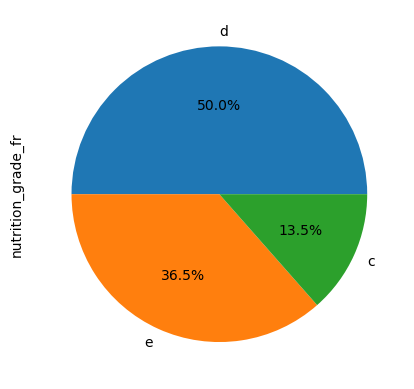

In [21]:
reponse = 5
while not (reponse == 1 or reponse == 2) :
    reponse = int(input('Entrez 1 pour prendre ou 2 pour perdre du poids : '))
    
test = app(reponse)
test["nutrition_grade_fr"].value_counts().plot(kind='pie', autopct = lambda x: str(round(x, 2)) + '%')

Entrez 1 pour prendre ou 2 pour perdre du poids : 2
Combien de produits voulez-vous afficher : 200


<AxesSubplot:ylabel='nutrition_grade_fr'>

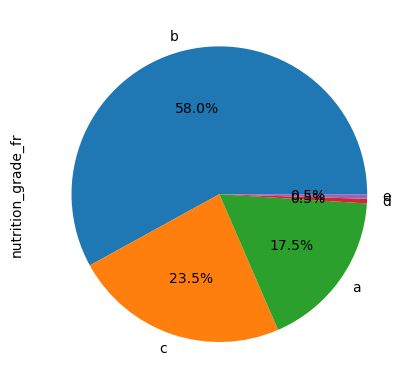

In [22]:
reponse = 5
while not (reponse == 1 or reponse == 2) :
    reponse = int(input('Entrez 1 pour prendre ou 2 pour perdre du poids : '))
    
test = app(reponse)
test["nutrition_grade_fr"].value_counts().plot(kind='pie', autopct = lambda x: str(round(x, 2)) + '%')

In [33]:
def app2(reponse) :    
    data2 = data[(data['nutrition_grade_fr'] == 'a') | (data['nutrition_grade_fr'] == 'b')]
    
    taille = int(input('Combien de produits voulez-vous afficher : '))
    if reponse == 1 :
        data_prise = data2.sort_values(by = 'energy_100g', ascending = False)
        return(data_prise[['url', 'product_name', 'main_category_fr', "nutrition_grade_fr"]].head(taille))
    
    if reponse == 2 : 
        data_perte = data2.sort_values(by = ['energy_100g', 'fiber_100g', 'sugars_100g', 'fat_100g'], ascending = [True, False,True,True])
        return(data_perte[['url', 'product_name', 'main_category_fr', "nutrition_grade_fr"]].head(taille))


Combien de produits voulez-vous afficher : 200


<AxesSubplot:ylabel='nutrition_grade_fr'>

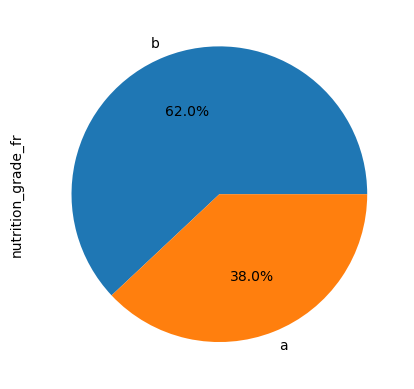

In [34]:
test = app2(1)
test["nutrition_grade_fr"].value_counts().plot(kind='pie', autopct = lambda x: str(round(x, 2)) + '%')

Combien de produits voulez-vous afficher : 200


<AxesSubplot:ylabel='nutrition_grade_fr'>

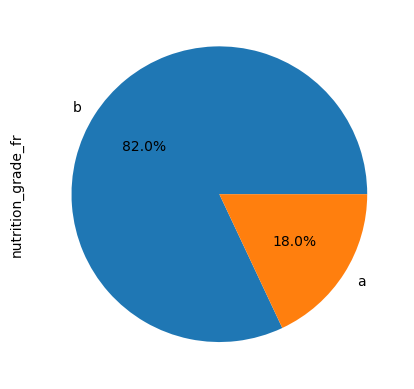

In [35]:
test = app2(2)
test["nutrition_grade_fr"].value_counts().plot(kind='pie', autopct = lambda x: str(round(x, 2)) + '%')